<a href="https://colab.research.google.com/github/NguyenTrucDaoNguyen/navigation/blob/master/Nanoparticles_nis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install gekko Run this command first
!pip install gekko

     |████████████████████████████████| 10.8MB 5.0MB/s 


apm 35.196.131.30_gk_model3 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.0
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            3
   Constants    :            0
   Variables    :           16
   Intermediates:            0
   Connections  :            6
   Equations    :           11
   Residuals    :           11
 
 Number of state variables:          13300
 Number of total equations: -        11100
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :           2200
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

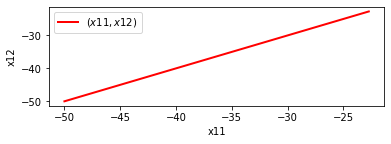

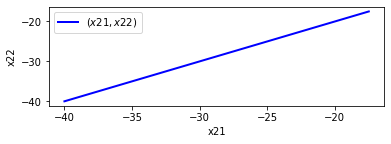

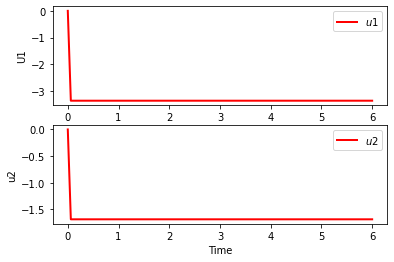

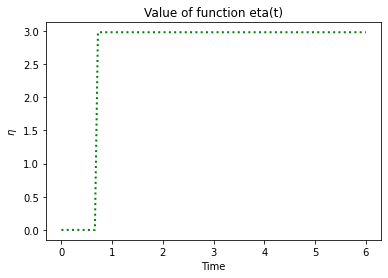

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from gekko import GEKKO

m=GEKKO()

#initialize final time and create partition of [0,T]
nt=101
T=6
m.time=np.linspace(0,T,nt)

#Initial conditions and other constants
x11zero=-50
x12zero=-50
x21zero=-40
x22zero=-40

R=6
s1=3
s2=1
sq2=np.sqrt(2)/2

angle=math.radians(225)
costheta=np.cos(angle)
sintheta=np.sin(angle)

#ControlParameters
u1=m.MV(value=0,lb=-3.37,ub=3.37)
u1.STATUS=1
u1.DCOST=0
u2=m.MV(value=0,lb=-1.685,ub=1.685)
u2.STATUS=1
u2.DCOST=0


#Variables
x11=m.Var(value=x11zero, lb=x11zero, ub=0)
x12=m.Var(value=x12zero,lb=x12zero,ub=0)
x21=m.Var(value=x21zero,lb=x21zero,ub=0)
x22=m.Var(value=x22zero,lb=x22zero,ub=0)
n=m.Var(value=0)



#Equations

#set eta (n) to zero if ||x1-x2||>=2R
n=m.if2(m.abs2(x11-x21)+m.abs2(x12-x22)-2*R, .5*(-3*sq2*u1+sq2*u2),0)

#Define all control equations and constraints
m.Equation(x11.dt()==-n+s1*u1*costheta) 
m.Equation(x12.dt()==-n+s1*u1*sintheta) 
m.Equation(x21.dt()==n+s2*u2*costheta) 
m.Equation(x22.dt()==n+s2*u2*sintheta)
m.Equation(u1==2*u2)

#Allows for x(T) in the Objective
p=np.zeros(nt)
p[-1]=1.0
final=m.Param(value=p)  

#Objective Function
m.Obj((final*x11-final*x21)**2+(final*x12**2+final*x22)**2)

#Various modes that allow to select right solver
m.options.IMODE=6 #6 CTL simultaneous, 9 CTL sequential
m.options.NODES=9
m.options.MV_TYPE=1 #linear interpolation between endpoints
m.options.SOLVER=3
m.solve(disp=True)


#Oupout
#can print out the path of where various important files are that document the problem  
#I haven't checked for this to work on google drive.  May need to mount drive first to use this in Colab
#print(m.path) 

print('\n\nObjective=min', r'(x11(T)-x21(T))**2+(x21(T)-x22(T))**2:')


plt.figure(1)

plt.subplot(2,1,1)
plt.plot(x11.value,x12.value,'r-',LineWidth=2, label=r'$(x11,x12)$')
plt.legend(loc='best')
plt.xlabel('x11')
plt.ylabel('x12')
plt.show()

plt.subplot(2,1,2)
plt.plot(x21.value,x22.value,'b-',LineWidth=2, label=r'$(x21,x22)$')
plt.legend(loc='best')
plt.xlabel('x21')
plt.ylabel('x22')
plt.show()


plt.figure(2)
plt.subplot(2,1,1)
plt.plot(m.time,u1,'r-',LineWidth=2, label=r'$u1$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('U1')
# plt.show()
plt.subplot(2,1,2)
plt.plot(m.time,u2,'r-',LineWidth=2, label=r'$u2$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('u2')

plt.show()
plt.figure(3)
plt.plot(m.time,n,'g:', LineWidth=2)
plt.xlabel('Time')
plt.ylabel('$\eta$')
plt.title('Value of function eta(t)')
plt.show()